## Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import os

np.random.seed(1337)  # for reproducibility
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error

from dbn.tensorflow import SupervisedDBNRegression

## Define Model Settings

In [2]:
RBM_EPOCHS = 5
DBN_EPOCHS = 150
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [20, 50, 100]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

## Define Directory, Road, and Year

In [3]:
# Read the dataset
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"
DATASET_DIVISION = "seasonWet"
DIR = "../../../datasets/Thesis Datasets/"
OUTPUT_DIR = "PM1/Rolling 3/"
MODEL_DIR = "PM1/Rolling 3/"

'''''''Training dataset'''''''
WP = False
WEEKDAY = False
CONNECTED_ROADS = False
CONNECTED_1 = ["Antipolo"]
trafficDT = "recon_traffic" #orig_traffic   recon_traffic
featureEngineering = "Rolling" #Rolling   Expanding   Rolling and Expanding
timeFE = "today" #today yesterday
timeConnected = "today"
ROLLING_WINDOW = 3
EXPANDING_WINDOW = 3
RECON_SHIFT = 96
# RECON_FE_WINDOW = 48

In [4]:
def addWorkingPeakFeatures(df):
    result_df = df.copy()

    # Converting the index as date
    result_df.index = pd.to_datetime(result_df.index)
    
    # Create column work_day
    result_df['work_day'] = ((result_df.index.dayofweek) < 5).astype(int)

    # Consider non-working holiday
    if DATASET_DIVISION is not "seasonWet":

        # Jan
        result_df.loc['2015-01-01', 'work_day'] = 0
        result_df.loc['2015-01-02', 'work_day'] = 0

        # Feb
        result_df.loc['2015-02-19', 'work_day'] = 0
        result_df.loc['2015-02-25', 'work_day'] = 0

        # Apr
        result_df.loc['2015-04-02', 'work_day'] = 0
        result_df.loc['2015-04-03', 'work_day'] = 0
        result_df.loc['2015-04-09', 'work_day'] = 0

        # May
        result_df.loc['2015-05-01', 'work_day'] = 0

    # Jun
    result_df.loc['2015-06-12', 'work_day'] = 0
    result_df.loc['2015-06-24', 'work_day'] = 0

    # Jul
    result_df.loc['2015-07-17', 'work_day'] = 0

    # Aug
    result_df.loc['2015-08-21', 'work_day'] = 0
    result_df.loc['2015-08-31', 'work_day'] = 0

    # Sep
    result_df.loc['2015-08-25', 'work_day'] = 0

    if DATASET_DIVISION is not "seasonWet":
        # Nov
        result_df.loc['2015-11-30', 'work_day'] = 0

        # Dec
        result_df.loc['2015-12-24', 'work_day'] = 0
        result_df.loc['2015-12-25', 'work_day'] = 0
        result_df.loc['2015-12-30', 'work_day'] = 0
        result_df.loc['2015-12-31', 'work_day'] = 0

    # Consider class suspension
    if DATASET_DIVISION is not "seasonWet":
        # Jan
        result_df.loc['2015-01-08', 'work_day'] = 0
        result_df.loc['2015-01-09', 'work_day'] = 0
        result_df.loc['2015-01-14', 'work_day'] = 0
        result_df.loc['2015-01-15', 'work_day'] = 0
        result_df.loc['2015-01-16', 'work_day'] = 0
        result_df.loc['2015-01-17', 'work_day'] = 0

    # Jul
    result_df.loc['2015-07-06', 'work_day'] = 0
    result_df.loc['2015-07-08', 'work_day'] = 0
    result_df.loc['2015-07-09', 'work_day'] = 0
    result_df.loc['2015-07-10', 'work_day'] = 0

    # Aug
    result_df.loc['2015-08-10', 'work_day'] = 0
    result_df.loc['2015-08-11', 'work_day'] = 0

    # Sep
    result_df.loc['2015-09-10', 'work_day'] = 0

    # Oct
    result_df.loc['2015-10-02', 'work_day'] = 0
    result_df.loc['2015-10-19', 'work_day'] = 0

    if DATASET_DIVISION is not "seasonWet":
        # Nov
        result_df.loc['2015-11-16', 'work_day'] = 0
        result_df.loc['2015-11-17', 'work_day'] = 0
        result_df.loc['2015-11-18', 'work_day'] = 0
        result_df.loc['2015-11-19', 'work_day'] = 0
        result_df.loc['2015-11-20', 'work_day'] = 0

        # Dec
        result_df.loc['2015-12-16', 'work_day'] = 0
        result_df.loc['2015-12-18', 'work_day'] = 0

    result_df['peak_hour'] = 0

    # Set morning peak hour

    start = datetime.time(7,0,0)
    end = datetime.time(10,0,0)

    result_df.loc[result_df.between_time(start, end).index, 'peak_hour'] = 1

    # Set afternoon peak hour

    start = datetime.time(16,0,0)
    end = datetime.time(19,0,0)

    result_df.loc[result_df.between_time(start, end).index, 'peak_hour'] = 1
    
    result_df
    
    return result_df

In [5]:
def reconstructDT(df, pastTraffic=False, trafficFeatureNeeded=[]):
    result_df = df.copy()

    # Converting the index as date
    result_df.index = pd.to_datetime(result_df.index, format='%d/%m/%Y %H:%M')
    result_df['month'] = result_df.index.month
    result_df['day'] = result_df.index.day
    result_df['hour'] = result_df.index.hour
    result_df['min'] = result_df.index.minute    
    result_df['dayOfWeek'] = result_df.index.dayofweek
    
    if pastTraffic:
        for f in trafficFeatureNeeded:
            result_df[f + '-' + str(RECON_SHIFT*15) + "mins"] = result_df[f].shift(RECON_SHIFT)
            
    result_df = result_df.iloc[RECON_SHIFT:, :]
    
    for f in range(len(result_df.columns)):
        result_df[result_df.columns[f]] = normalize(result_df[result_df.columns[f]])

    return result_df

In [6]:
def getNeededFeatures(columns, arrFeaturesNeed, featureEngineering="Original"):
    to_remove = []
    if len(arrFeaturesNeed) == 0: #all features aren't needed
        to_remove += range(0, len(columns))

    else:
        if featureEngineering == "Original":
            compareTo = " "
        elif featureEngineering == "Rolling" or featureEngineering == "Expanding":
            compareTo = "_"
            
        for f in arrFeaturesNeed:
            for c in range(0, len(columns)):
                if f not in columns[c].split(compareTo)[0] and columns[c].split(compareTo)[0] not in arrFeaturesNeed:
                    to_remove.append(c)
                if len(columns[c].split(compareTo)) > 1:
                    if "Esum" in columns[c].split(compareTo)[1]: #Removing all Expanding Sum 
                        to_remove.append(c)
                        
    return to_remove

In [7]:
def normalize(data):
    y = pd.to_numeric(data)
    y = np.array(y.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y)
    y = y.reshape(1, -1)[0]
    return y

<br><br>
### Preparing Traffic Dataset

#### Importing Original Traffic (wo new features)

In [8]:
TRAFFIC_DIR = DIR + "mmda/"
TRAFFIC_FILENAME = "mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
orig_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
orig_traffic = orig_traffic.fillna(0)

#Converting index to date and time, and removing 'dt' column
orig_traffic.index = pd.to_datetime(orig_traffic.dt, format='%d/%m/%Y %H:%M')
cols_to_remove = [0]
cols_to_remove = getNeededFeatures(orig_traffic.columns, ["statusN"])
orig_traffic.drop(orig_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
orig_traffic.head()

if WEEKDAY:
    orig_traffic = orig_traffic[((orig_traffic.index.dayofweek) < 5)]
orig_traffic.head()

,statusN
dt,
2015-06-01 00:00:00,0.908264
2015-06-01 00:15:00,0.909505
2015-06-01 00:30:00,0.910818
2015-06-01 00:45:00,0.912204
2015-06-01 01:00:00,0.913664


In [9]:
TRAFFIC_DIR = DIR + "mmda/Rolling/" + DATASET_DIVISION + "/"
TRAFFIC_FILENAME = "eng_win" + str(ROLLING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
rolling_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)

cols_to_remove = [0, 1, 2]
cols_to_remove += getNeededFeatures(rolling_traffic.columns, ["statusN"], "Rolling")

rolling_traffic.index = pd.to_datetime(rolling_traffic.dt, format='%Y-%m-%d %H:%M')

rolling_traffic.drop(rolling_traffic.columns[[cols_to_remove]], axis=1, inplace=True)

if WEEKDAY:
    rolling_traffic = rolling_traffic[((rolling_traffic.index.dayofweek) < 5)]
        
rolling_traffic.head()

,statusN_Rmean=3,statusN_Rmin=3,statusN_Rmax=3
dt,,,
2015-06-01 00:00:00,0.000000,0.000000,0.000000
2015-06-01 00:15:00,0.000000,0.000000,0.000000
2015-06-01 00:30:00,0.302755,0.000000,0.908264
2015-06-01 00:45:00,0.605923,0.000000,0.909505
2015-06-01 01:00:00,0.909529,0.908264,0.910818


In [10]:
TRAFFIC_DIR = DIR + "mmda/Expanding/" + DATASET_DIVISION + "/"
TRAFFIC_FILENAME = "eng_win" + str(EXPANDING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
expanding_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)

cols_to_remove = [0, 1, 2, 5]
cols_to_remove += getNeededFeatures(expanding_traffic.columns, ["statusN"], "Rolling")

expanding_traffic.index = pd.to_datetime(expanding_traffic.dt, format='%d/%m/%Y %H:%M')

expanding_traffic.drop(expanding_traffic.columns[[cols_to_remove]], axis=1, inplace=True)

if WEEKDAY:
    expanding_traffic = expanding_traffic[((expanding_traffic.index.dayofweek) < 5)]
expanding_traffic.head()

,statusN_Emin=3,statusN_Emax=3,statusN_Emean=3
dt,,,
2015-06-01 00:00:00,0.908264,0.908264,0.908264
2015-06-01 00:15:00,0.908264,0.909505,0.908885
2015-06-01 00:30:00,0.908264,0.910818,0.909529
2015-06-01 00:45:00,0.912204,0.912204,0.912204
2015-06-01 01:00:00,0.912204,0.913664,0.912934


In [11]:
recon_traffic = reconstructDT(orig_traffic, pastTraffic=True, trafficFeatureNeeded=['statusN'])
recon_traffic.head()

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,statusN,month,day,hour,min,dayOfWeek,statusN-1440mins
dt,,,,,,,
2015-06-02 00:00:00,0.438567,0.0,0.033333,0.000000,0.000000,0.166667,0.908264
2015-06-02 00:15:00,0.555569,0.0,0.033333,0.000000,0.333333,0.166667,0.909505
2015-06-02 00:30:00,0.683338,0.0,0.033333,0.000000,0.666667,0.166667,0.910818
2015-06-02 00:45:00,0.795359,0.0,0.033333,0.000000,1.000000,0.166667,0.912204
2015-06-02 01:00:00,0.874074,0.0,0.033333,0.043478,0.000000,0.166667,0.913664


In [12]:
connected_roads = []

for c in CONNECTED_1:
    TRAFFIC_DIR = DIR + "mmda/"
    TRAFFIC_FILENAME = "mmda_" + c + "_" + YEAR + "_" + DATASET_DIVISION
    temp = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
    temp = temp.fillna(0)

    #Converting index to date and time, and removing 'dt' column
    temp.index = pd.to_datetime(temp.dt, format='%d/%m/%Y %H:%M')
    cols_to_remove = [0]
    cols_to_remove = getNeededFeatures(temp.columns, ["statusN"])
    temp.drop(temp.columns[[cols_to_remove]], axis=1, inplace=True)
    
    if WEEKDAY:
        temp = temp[((temp.index.dayofweek) < 5)]
    
    for f in range(len(temp.columns)):
        temp[temp.columns[f]] = normalize(temp[temp.columns[f]])
        temp = temp.rename(columns={temp.columns[f]: temp.columns[f] +"(" + c + ")"})
    connected_roads.append(temp)
    
connected_roads[0].head()

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,statusN(Antipolo)
dt,
2015-06-01 00:00:00,0.319231
2015-06-01 00:15:00,0.316331
2015-06-01 00:30:00,0.315411
2015-06-01 00:45:00,0.316171
2015-06-01 01:00:00,0.318315


### Merging datasets

In [13]:
if trafficDT == "orig_traffic":
    arrDT = [orig_traffic]
    
    if CONNECTED_ROADS:
        for c in connected_roads:
            arrDT.append(c)
    
elif trafficDT == "recon_traffic":
    arrDT = [recon_traffic]
    
    if CONNECTED_ROADS:
        timeConnected = "today"
        print("TimeConnected = " + timeConnected)
        for c in connected_roads:
            if timeConnected == "today":
                startIndex = np.absolute(len(arrDT[0])-len(c))
                endIndex = len(c)
            elif timeConnected == "yesterday":
                startIndex = 0
                endIndex = len(rolling_traffic) - RECON_SHIFT
                c = c.rename(columns={c.columns[0]: c.columns[0] + "-" + str(RECON_SHIFT*15) + "mins"})


            c = c.iloc[startIndex:endIndex, :]
            print("Connected Road Start time: " + str(c.index[0]))
            c.index = arrDT[0].index
            arrDT.append(c)
        print(str(startIndex) + " " + str(endIndex))

        
if featureEngineering != "":
    print("Adding Feature Engineering")
    
    print("TimeConnected = " + timeFE)

    
    if timeFE == "today":
        startIndex = np.absolute(len(arrDT[0])-len(rolling_traffic))
        endIndex = len(rolling_traffic)
    elif timeFE == "yesterday":
        startIndex = 0
        endIndex = len(rolling_traffic) - RECON_SHIFT
    
    if featureEngineering == "Rolling":
        temp = rolling_traffic.iloc[startIndex:endIndex, :]
        arrDT.append(temp)

    elif featureEngineering == "Expanding":
        temp = expanding_traffic.iloc[startIndex:endIndex, :]
        arrDT.append(temp)

    elif featureEngineering == "Rolling and Expanding":
        print(str(startIndex) + " " + str(endIndex))
        
        #Rolling
        temp = rolling_traffic.iloc[startIndex:endIndex, :]
        temp.index = arrDT[0].index
        arrDT.append(temp)
        
        #Expanding
        temp = expanding_traffic.iloc[startIndex:endIndex, :]
        temp.index = arrDT[0].index
        arrDT.append(temp)
        
merged_dataset = pd.concat(arrDT, axis=1)
if "Rolling" in featureEngineering:
    merged_dataset = merged_dataset.iloc[ROLLING_WINDOW+1:, :]
    
if WP:
    merged_dataset = addWorkingPeakFeatures(merged_dataset)
    print("Adding working / peak days")    

merged_dataset

Adding Feature Engineering
TimeConnected = today


,statusN,month,day,hour,min,dayOfWeek,statusN-1440mins,statusN_Rmean=3,statusN_Rmin=3,statusN_Rmax=3
dt,,,,,,,,,,
2015-06-02 01:00:00,0.874074,0.0,0.033333,0.043478,0.000000,0.166667,0.913664,0.559158,0.438567,0.683338
2015-06-02 01:15:00,0.921143,0.0,0.033333,0.043478,0.333333,0.166667,0.915199,0.678089,0.555569,0.795359
2015-06-02 01:30:00,0.942596,0.0,0.033333,0.043478,0.666667,0.166667,0.916810,0.784257,0.683338,0.874074
2015-06-02 01:45:00,0.944464,0.0,0.033333,0.043478,1.000000,0.166667,0.918500,0.863525,0.795359,0.921143
2015-06-02 02:00:00,0.932778,0.0,0.033333,0.086957,0.000000,0.166667,0.920268,0.912604,0.874074,0.942596
2015-06-02 02:15:00,0.913568,0.0,0.033333,0.086957,0.333333,0.166667,0.922118,0.936068,0.921143,0.944464
2015-06-02 02:30:00,0.892865,0.0,0.033333,0.086957,0.666667,0.166667,0.924049,0.939946,0.932778,0.944464
2015-06-02 02:45:00,0.876699,0.0,0.033333,0.086957,1.000000,0.166667,0.926063,0.930270,0.913568,0.944464
2015-06-02 03:00:00,0.871102,0.0,0.033333,0.130435,0.000000,0.166667,0.928163,0.913070,0.892865,0.932778


### Adding Working / Peak Features

In [14]:
if WP:
    merged_dataset = addWorkingPeakFeatures(merged_dataset)
    print("Adding working / peak days")

## Preparing Training dataset

### Merge Original (and Rolling and Expanding)

In [15]:
# To-be Predicted variable 
Y = merged_dataset.statusN
Y = Y.fillna(0)

In [16]:
# Training Data
X = merged_dataset
X = X.drop(X.columns[[0]], axis=1)

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.67, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Data scaling
# min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)

#Print training and testing data
pd.concat([X, Y.to_frame()], axis=1).head()

,month,day,hour,min,dayOfWeek,statusN-1440mins,statusN_Rmean=3,statusN_Rmin=3,statusN_Rmax=3,statusN
dt,,,,,,,,,,
2015-06-02 01:00:00,0.0,0.033333,0.043478,0.000000,0.166667,0.913664,0.559158,0.438567,0.683338,0.874074
2015-06-02 01:15:00,0.0,0.033333,0.043478,0.333333,0.166667,0.915199,0.678089,0.555569,0.795359,0.921143
2015-06-02 01:30:00,0.0,0.033333,0.043478,0.666667,0.166667,0.916810,0.784257,0.683338,0.874074,0.942596
2015-06-02 01:45:00,0.0,0.033333,0.043478,1.000000,0.166667,0.918500,0.863525,0.795359,0.921143,0.944464
2015-06-02 02:00:00,0.0,0.033333,0.086957,0.000000,0.166667,0.920268,0.912604,0.874074,0.942596,0.932778


<br><br>
## Training Model

In [17]:
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=HIDDEN_LAYER_STRUCT,
                                    learning_rate_rbm=RBM_LEARNING_RATE,
                                    learning_rate=DBN_LEARNING_RATE,
                                    n_epochs_rbm=RBM_EPOCHS,
                                    n_iter_backprop=DBN_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    activation_function=ACTIVE_FUNC)
regressor.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.600877
>> Epoch 2 finished 	RBM Reconstruction error 0.567511
>> Epoch 3 finished 	RBM Reconstruction error 0.521251
>> Epoch 4 finished 	RBM Reconstruction error 0.471193
>> Epoch 5 finished 	RBM Reconstruction error 0.412250
>> Epoch 1 finished 	RBM Reconstruction error 0.150905
>> Epoch 2 finished 	RBM Reconstruction error 0.141888
>> Epoch 3 finished 	RBM Reconstruction error 0.133112
>> Epoch 4 finished 	RBM Reconstruction error 0.125336
>> Epoch 5 finished 	RBM Reconstruction error 0.117369
>> Epoch 1 finished 	RBM Reconstruction error 0.045284
>> Epoch 2 finished 	RBM Reconstruction error 0.038918
>> Epoch 3 finished 	RBM Reconstruction error 0.038393
>> Epoch 4 finished 	RBM Reconstruction error 0.037598
>> Epoch 5 finished 	RBM Reconstruction error 0.036662
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss 0.056863
>> Epoch 1 finished 	ANN training loss 0.048765
>>

>> Epoch 149 finished 	ANN training loss 0.009140
[END] Fine tuning step


SupervisedDBNRegression(batch_size=28, dropout_p=0, l2_regularization=1.0,
            learning_rate=0.01, n_iter_backprop=150, verbose=True)

In [18]:
#To check RBM Loss Errors:
rbm_error = regressor.unsupervised_dbn.rbm_layers[0].rbm_loss_error
#To check DBN Loss Errors
dbn_error = regressor.dbn_loss_error

<br><br>
## Testing Model

In [19]:
# Test
min_max_scaler = MinMaxScaler()
X_test = min_max_scaler.fit_transform(X_test)
Y_pred = regressor.predict(X_test)

r2score = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
print('Done.\nR-squared: %.3f\nRMSE: %.3f \nMAE: %.3f' % (r2score, rmse, mae))

Done.
R-squared: 0.892
RMSE: 0.105 
MAE: 0.063


In [20]:
print(len(Y_pred))
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test}

df = pd.DataFrame(data=d)
df.head()

9774


,Actual,Predicted
0,0.916327,0.924072
1,0.870975,0.926641
2,0.794997,0.916551
3,0.686400,0.892901
4,0.562583,0.845103


In [21]:
# Save the model
if MODEL_DIR != "":
    directory = "models/" + MODEL_DIR
    if not os.path.exists(directory):
        print("Making Directory")
        os.makedirs(directory)

regressor.save('models/' + MODEL_DIR + 'pm1_' + ROAD + '_' + YEAR + '.pkl')

Making Directory


### Results and Analysis below

In [22]:
import matplotlib.pyplot as plt

##### Printing Predicted and Actual Results

In [23]:
startIndex = merged_dataset.shape[0] - Y_pred.shape[0]
dt = merged_dataset.index[startIndex:,]
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test, 'dt': dt}
df = pd.DataFrame(data=d)
df.head()

,Actual,Predicted,dt
0,0.916327,0.924072,2015-07-22 04:30:00
1,0.870975,0.926641,2015-07-22 04:45:00
2,0.794997,0.916551,2015-07-22 05:00:00
3,0.686400,0.892901,2015-07-22 05:15:00
4,0.562583,0.845103,2015-07-22 05:30:00


In [24]:
df.tail()

,Actual,Predicted,dt
9769,0.307593,0.351495,2015-10-31 22:45:00
9770,0.289160,0.340902,2015-10-31 23:00:00
9771,0.284117,0.330905,2015-10-31 23:15:00
9772,0.304501,0.318472,2015-10-31 23:30:00
9773,0.360046,0.312291,2015-10-31 23:45:00


#### Visualize Actual and Predicted Traffic 

2015-07-22 04:30:00


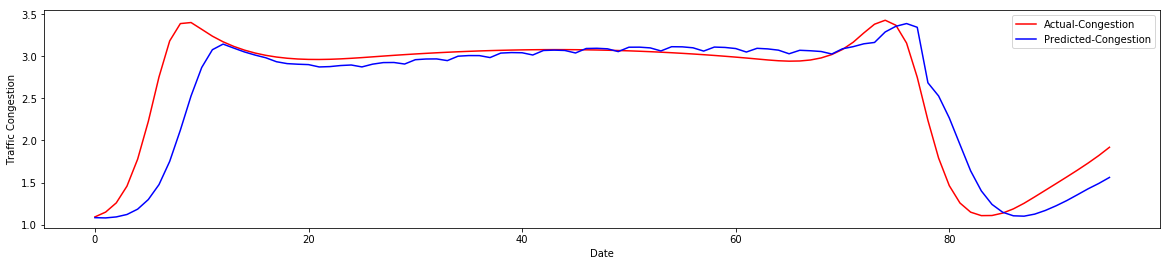

In [25]:
print(df.dt[0])
startIndex = 0
endIndex = 96
line1 = df.Actual.rdiv(1)
line2 = df.Predicted.rdiv(1)
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.figure(figsize=(20, 4))
plt.plot(line1[startIndex:endIndex], c='red', label="Actual-Congestion")
plt.plot(line2[startIndex:endIndex], c='blue', label="Predicted-Congestion")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Traffic Congestion")
plt.show()

In [26]:
if OUTPUT_DIR != "":
    directory = "output/" + OUTPUT_DIR
    if not os.path.exists(directory):
        print("Making Directory")
        os.makedirs(directory)

df.to_csv("output/" + OUTPUT_DIR + "pm1_" + ROAD + '_' + YEAR + EXT, index=False, encoding='utf-8')

#### Visualize trend of loss of RBM and DBN Training

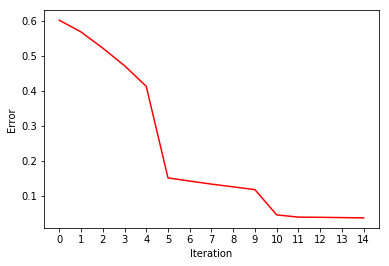

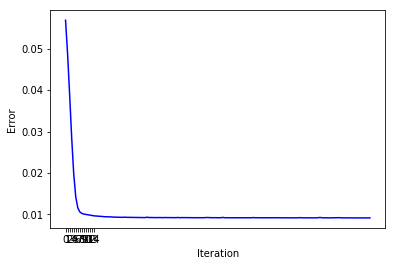

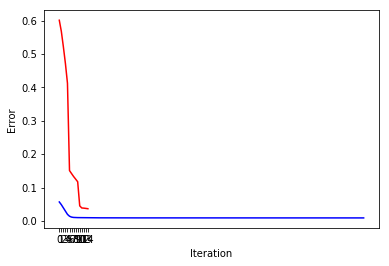

In [27]:
line1 = rbm_error
line2 = dbn_error
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()


plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()